In [1]:
import pandas as pd
import numpy as np

import FinanceDataReader as fdr

import tensorflow as tf
from tensorflow import keras

import PredictLSTM 

In [2]:
# Stock Price
# Train Dataset
df = fdr.DataReader('005930','2018-01-01', '2022-12-31')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2022-12-23,58200,58400,57700,58100,9829407,-0.016920
2022-12-26,58000,58100,57700,57900,6756411,-0.003442
2022-12-27,58000,58400,57900,58100,10667027,0.003454


In [3]:
df = df.drop(["Volume", "Change"], axis = 1)
df = df.rename(columns={"Close":"y"})


In [4]:
# Test Dataset
test_df = fdr.DataReader('005930','2023')
test_df = test_df.drop(["Volume", "Change"], axis = 1)
test_df = test_df.rename(columns={"Close":"y"})
test_df.shape

(192, 4)

In [5]:
train_lstm = PredictLSTM.Train_LSTM(33)
test_lstm = PredictLSTM.Test_LSTM()

In [6]:
seq_len = 5  
steps = 1  
metrics = "mse"

In [7]:
test_dataset = test_lstm.reshape_dataset(test_df)
x_test , y_test = test_lstm.sequential_dataset(test_dataset, seq_len, steps)

In [8]:
lstm_params = {
    "seq_len": seq_len,
    "epochs": 300, 
    "patience": 30,  
    "steps_per_epoch": 5, 
    "learning_rate": 0.01,
    "lstm_units": [64, 32], 
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3, 
}

In [9]:
# train model
train_lstm.fit_lstm(
    df=df,
    steps=steps,
    metrics=metrics,
    check_point_name = "1014_check",
    **lstm_params,
)

X_train: (858, 5, 3)
y_train: (858, 1)
X_val: (369, 5, 3)
y_val: (369, 1)
Epoch 1/300
1/5 [=====>........................] - ETA: 10s - loss: 1444890240.0000 - mse: 1444890240.0000
Epoch 1: val_loss improved from inf to 536414592.00000, saving model to checkpoint\lstm_1014_check.h5
5/5 [==============================] - 3s 123ms/step - loss: 1488852608.0000 - mse: 1488852608.0000 - val_loss: 536414592.0000 - val_mse: 536414592.0000 - lr: 0.0100
Epoch 2/300
1/5 [=====>........................] - ETA: 0s - loss: 302524544.0000 - mse: 302524544.0000
Epoch 2: val_loss improved from 536414592.00000 to 263531936.00000, saving model to checkpoint\lstm_1014_check.h5
5/5 [==============================] - 0s 28ms/step - loss: 556915200.0000 - mse: 556915200.0000 - val_loss: 263531936.0000 - val_mse: 263531936.0000 - lr: 0.0100
Epoch 3/300
1/5 [=====>........................] - ETA: 0s - loss: 172652896.0000 - mse: 172652896.0000
Epoch 3: val_loss did not improve from 263531936.00000
5/5 [======

In [10]:
train_lstm.plot_train_valid()

In [11]:
def calculate_metrics(df_fcst):
    true = df_fcst["y"]
    pred = df_fcst["y_pred"]

    mae = (true - pred).abs().mean()
    mse = ((true - pred) ** 2).mean()
    return {
        "mae": mae,
        "mse": mse
    }

In [12]:
# load model
model = keras.models.load_model('checkpoint/lstm_1014_check.h5')

In [13]:
# validation loss
df_pred_val = train_lstm.validation_pred_dataset()
val_loss = calculate_metrics(df_fcst=df_pred_val)[metrics]
# test loss
df_pred_test = test_lstm.test_pred_dataset(x_test, y_test, model)
test_loss = calculate_metrics(df_fcst=df_pred_test)[metrics]

print(f"{metrics} of val dataset: {round(val_loss, 3)}")
print(f"{metrics} of test dataset: {round(test_loss, 3)}")

mse of val dataset: 2395761.182
mse of test dataset: 2126058.573


In [14]:
test_lstm.plot_result()

In [15]:
# Compute lstm feature importance
df_fi = train_lstm.feature_importance_df()
df_fi

  0%|          | 0/3 [00:00<?, ?it/s]

,feature,mae
0,BASELINE,1177.101647
1,Open,1738.730532
2,High,2483.536871
3,Low,5988.420022


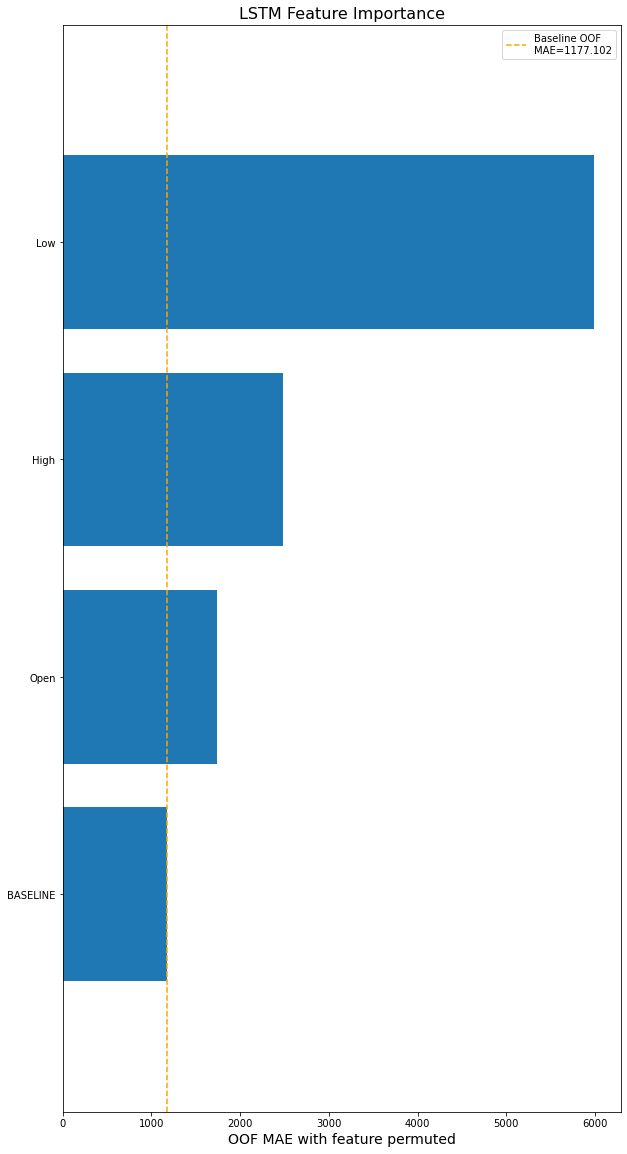

In [16]:
# Plot lstm feature importance
train_lstm.feature_importance_plot()